# Tennis Action Evaluator

## Introduction

### Problem

### Model Definition

#### State

#### Action

#### Rewards

### Data Processing

#### Raw Data

#### Extracted data

### Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [1]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: (0.5361596009975063, 0.24950967844844793)


## Deep Reinforcement Learning

### MC

#### Training

In [3]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 1.000  train_ave_loss: 0.258  train_ave_acc: 0.542  (9.25s - 1378.83s remaining) ave_loss: 0.25801078101232255 ave_acc: 0.5418354683230898
EPOCH: 2.000  train_ave_loss: 0.244  train_ave_acc: 0.586  (12.64s - 935.40s remaining) ave_loss: 0.24391748526207338 ave_acc: 0.5857233029326581
EPOCH: 3.000  train_ave_loss: 0.240  train_ave_acc: 0.586  (15.91s - 779.41s remaining) ave_loss: 0.23981960857412682 ave_acc: 0.5864835689980403
EPOCH: 4.000  train_ave_loss: 0.237  train_ave_acc: 0.604  (19.32s - 705.33s remaining) ave_loss: 0.23672695770379035 ave_acc: 0.6041860472659727
EPOCH: 5.000  train_ave_loss: 0.233  train_ave_acc: 0.611  (22.64s - 656.54s remaining) ave_loss: 0.23250513619407356 ave_acc: 0.611307788074557
EPOCH: 6.000  train_ave_loss: 0.224  train_ave_acc: 0.628  (25.94s - 622.49s remaining) ave_loss: 0.22377096022591214 ave_acc: 0.6282547201048713
EPOCH: 7.000  train_ave_loss: 0.219  train_ave_acc: 0.619  (29.23s - 597.16s remaining) ave_loss: 0.21921582890761868 ave_acc

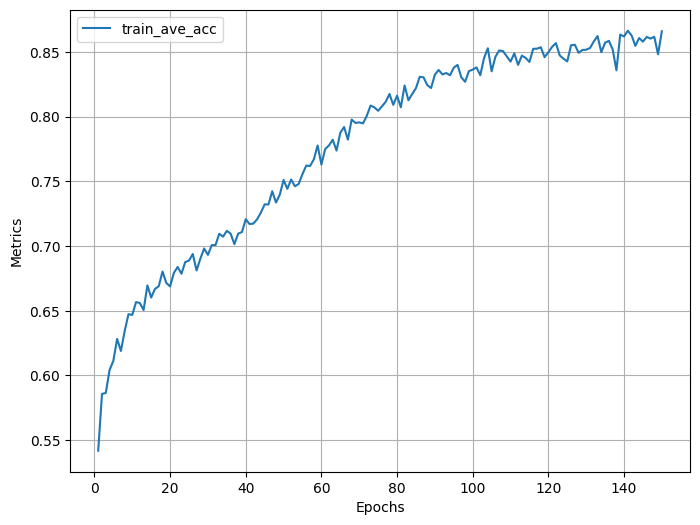

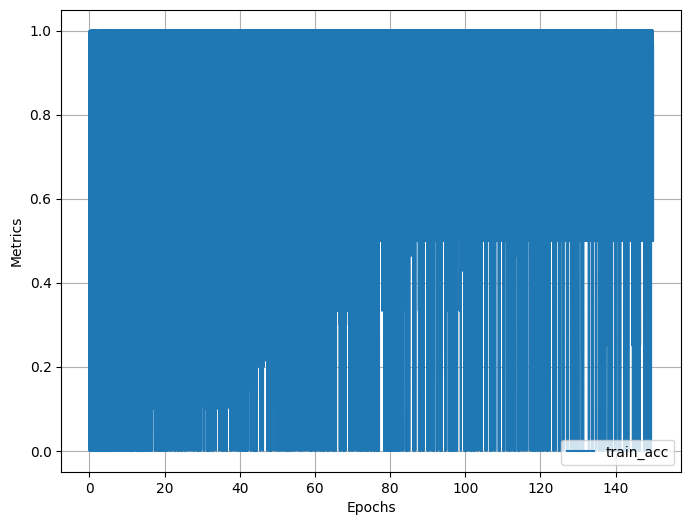

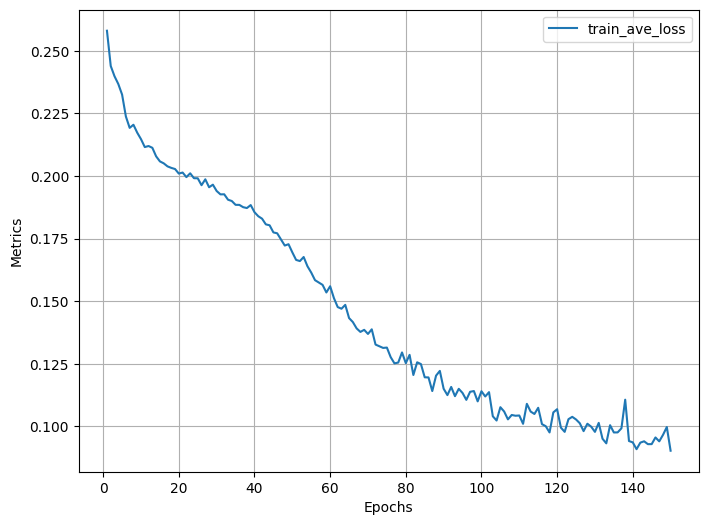

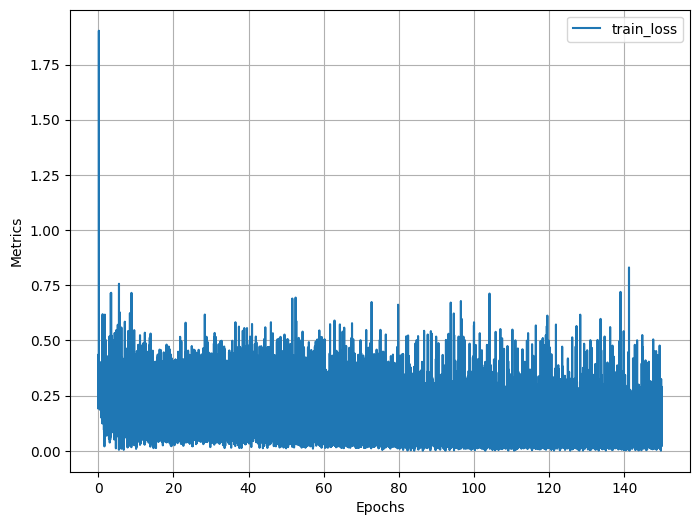

In [4]:
nn_mc_report.plot('train_ave_acc')
nn_mc_report.plot('train_acc')
nn_mc_report.plot('train_ave_loss')
nn_mc_report.plot('train_loss')

#### Evaluation

In [5]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_score, nn_mc_mse = eval.score_model(test_dataset, nn_mc_predict)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_seq_score, nn_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_mc_predict_seq)

print(f"NN MC Accuracy: {nn_mc_score}")
print(f"NN MC MSE: {nn_mc_mse}")
print(f"NN MC Seq Accuracy: {nn_mc_seq_score}")
print(f"NN MC Seq MSE: {nn_mc_seq_mse}")

NN MC Accuracy: 0.5673316708229427
NN MC MSE: 0.3237241997558623
NN MC Seq Accuracy: 0.5748129675810474
NN MC Seq MSE: 0.35336939137651296


### SARSA

#### Training (Without MC Init)

In [6]:
import d_sarsa

nn_sarsa_model, nn_sarsa_report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 1.000  train_ave_loss: 0.171  train_ave_acc: 0.499  (2.58s - 383.95s remaining) ave_loss: 0.17132861274253589 ave_acc: 0.49904243205389215
EPOCH: 2.000  train_ave_loss: 0.132  train_ave_acc: 0.523  (5.12s - 378.79s remaining) ave_loss: 0.13236181564865324 ave_acc: 0.5229357288027607
EPOCH: 3.000  train_ave_loss: 0.131  train_ave_acc: 0.528  (7.68s - 376.41s remaining) ave_loss: 0.130662705418804 ave_acc: 0.5283563865659532
EPOCH: 4.000  train_ave_loss: 0.127  train_ave_acc: 0.533  (10.24s - 373.86s remaining) ave_loss: 0.12718401498043816 ave_acc: 0.5328759430190979
EPOCH: 5.000  train_ave_loss: 0.125  train_ave_acc: 0.544  (12.74s - 369.44s remaining) ave_loss: 0.12457445859253581 ave_acc: 0.543649794731173
EPOCH: 6.000  train_ave_loss: 0.123  train_ave_acc: 0.536  (15.38s - 369.17s remaining) ave_loss: 0.12328067699398114 ave_acc: 0.5360039879530791
EPOCH: 7.000  train_ave_loss: 0.105  train_ave_acc: 0.572  (17.88s - 365.25s remaining) ave_loss: 0.1045481464292996 ave_acc: 0.5

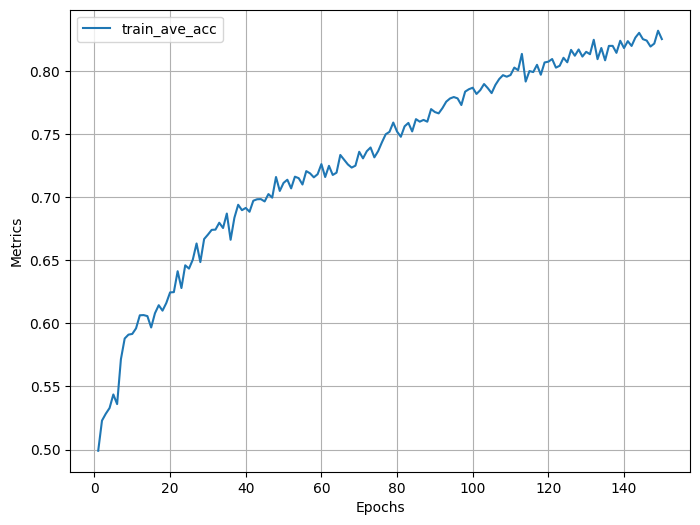

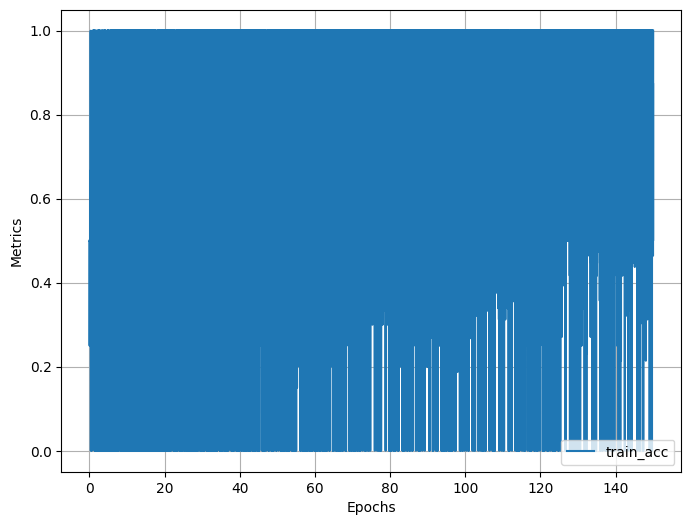

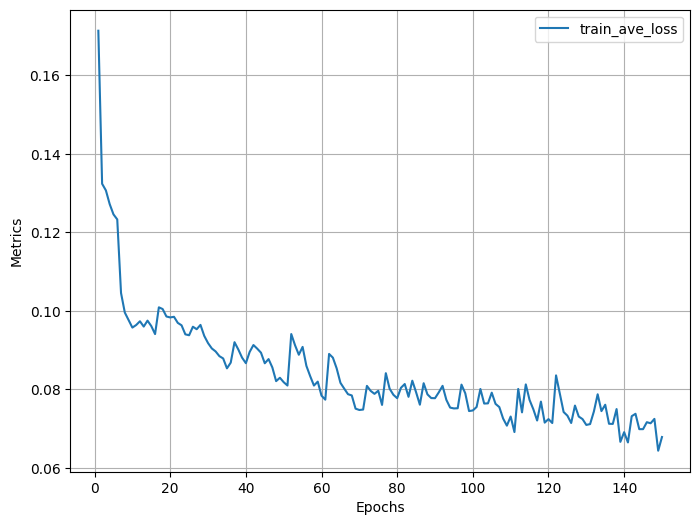

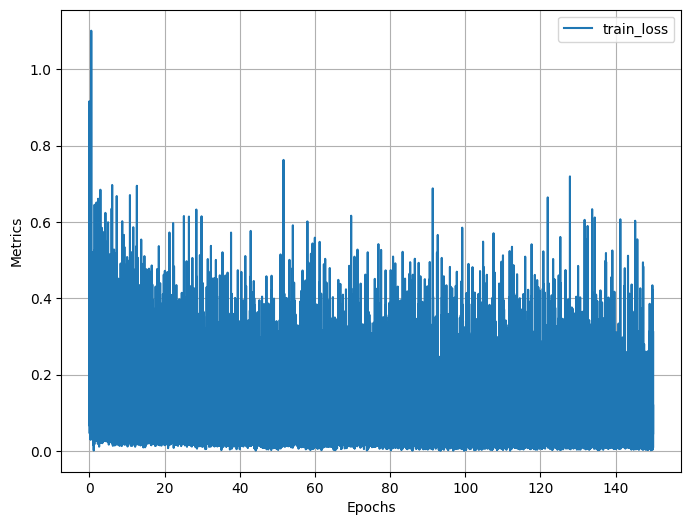

In [7]:
nn_sarsa_report.plot('train_ave_acc')
nn_sarsa_report.plot('train_acc')
nn_sarsa_report.plot('train_ave_loss')
nn_sarsa_report.plot('train_loss')

#### Evaluation (Without MC Init)

In [8]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_score, nn_sarsa_mse = eval.score_model(test_dataset, nn_predict)

def nn_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_seq_score, nn_sarsa_seq_mse = eval.score_model_sequential(test_dataset, nn_predict_seq)

print(f"NN Sarsa Accuracy: {nn_sarsa_score}")
print(f"NN Sarsa MSE: {nn_sarsa_mse}")
print(f"NN Sarsa Seq Accuracy: {nn_sarsa_seq_score}")
print(f"NN Sarsa Seq MSE: {nn_sarsa_seq_mse}")

NN Sarsa Accuracy: 0.5660847880299252
NN Sarsa MSE: 0.3169353089839692
NN Sarsa Seq Accuracy: 0.600997506234414
NN Sarsa Seq MSE: 0.273534254780734


#### Training (With MC Init)

In [9]:
import d_sarsa

nn_mc_state_dict = nn_mc_model.state_dict()
nn_sarsa_with_mc_model, nn_sarsa_with_mc_report = d_sarsa.train(save=False, use_mc=False, init_state_dict=nn_mc_state_dict)

Init state dictionary was passed. Using that to initialize model_net.
EPOCH: 1.000  train_ave_loss: 0.081  train_ave_acc: 0.857  (2.63s - 391.95s remaining) ave_loss: 0.08116463038256484 ave_acc: 0.8571501312800811
EPOCH: 2.000  train_ave_loss: 0.071  train_ave_acc: 0.856  (5.20s - 384.63s remaining) ave_loss: 0.07066600906315787 ave_acc: 0.8556721373057192
EPOCH: 3.000  train_ave_loss: 0.070  train_ave_acc: 0.850  (7.76s - 380.34s remaining) ave_loss: 0.07017893347441276 ave_acc: 0.8496734857188546
EPOCH: 4.000  train_ave_loss: 0.069  train_ave_acc: 0.841  (10.32s - 376.76s remaining) ave_loss: 0.06935466180915352 ave_acc: 0.84071284638991
EPOCH: 5.000  train_ave_loss: 0.064  train_ave_acc: 0.857  (12.86s - 372.91s remaining) ave_loss: 0.06416500999272699 ave_acc: 0.856988289234427
EPOCH: 6.000  train_ave_loss: 0.069  train_ave_acc: 0.842  (15.39s - 369.37s remaining) ave_loss: 0.06949274616228564 ave_acc: 0.8420418738355885
EPOCH: 7.000  train_ave_loss: 0.090  train_ave_acc: 0.827  (

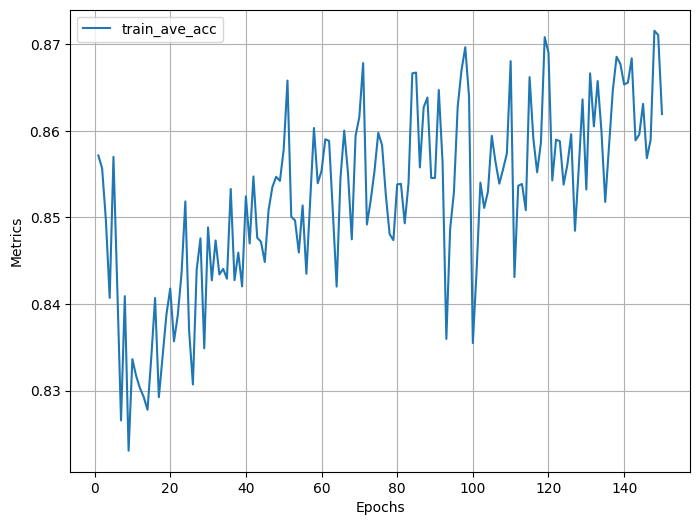

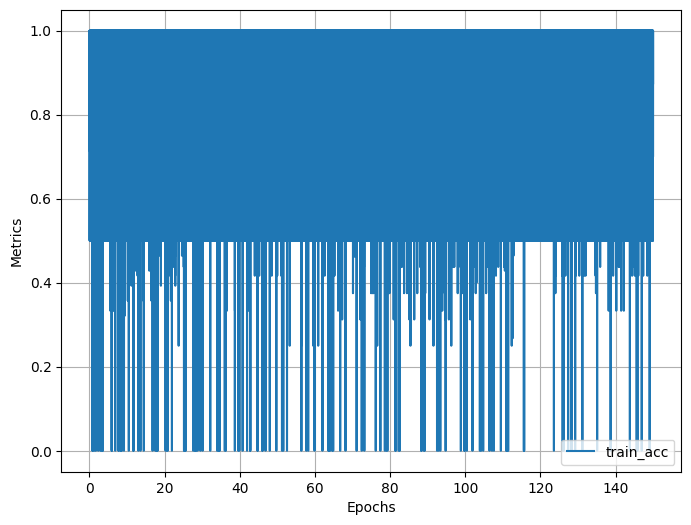

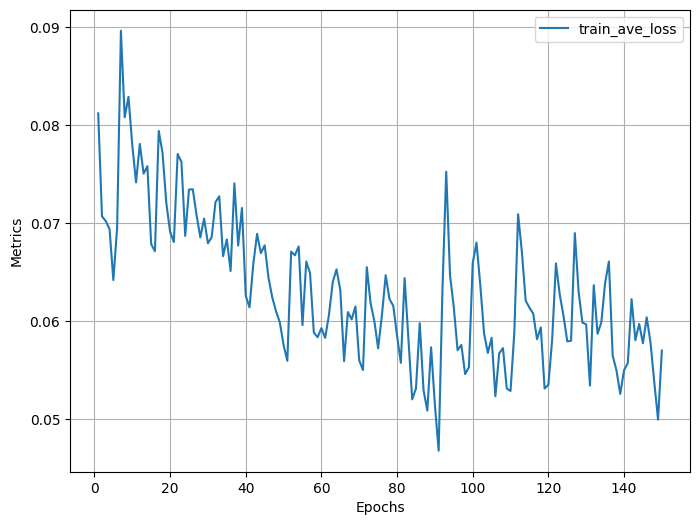

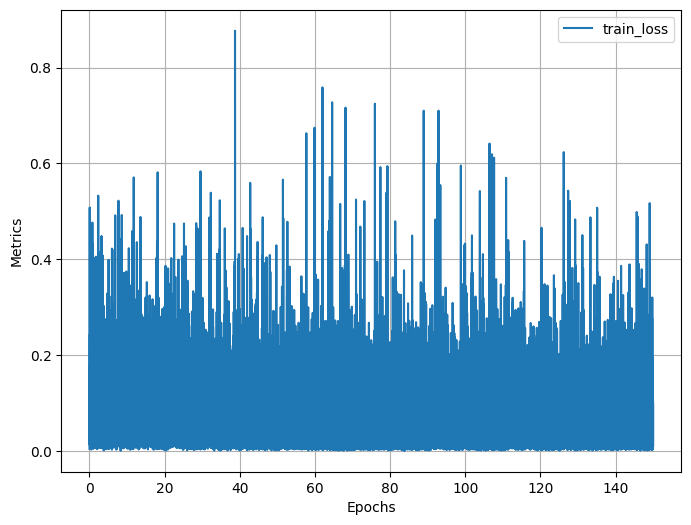

In [10]:
nn_sarsa_with_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_report.plot('train_acc')
nn_sarsa_with_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_report.plot('train_loss')

#### Evaluation (With MC Init)

In [11]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_with_mc_model.eval()
def nn_sarsa_with_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_score, nn_sarsa_with_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_predict)

def nn_sarsa_with_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_seq_score, nn_sarsa_with_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_predict_seq)

print(f"NN Sarsa With MC Init Accuracy: {nn_sarsa_with_mc_score}")
print(f"NN Sarsa With MC Init MSE: {nn_sarsa_with_mc_mse}")
print(f"NN Sarsa With MC Init Seq Accuracy: {nn_sarsa_with_mc_seq_score}")
print(f"NN Sarsa With MC Init Seq MSE: {nn_sarsa_with_mc_seq_mse}")

NN Sarsa With MC Init Accuracy: 0.5748129675810474
NN Sarsa With MC Init MSE: 0.3025117847716482
NN Sarsa With MC Init Seq Accuracy: 0.5910224438902744
NN Sarsa With MC Init Seq MSE: 0.3147719989112012


In [12]:
import os

model_dirpath = 'experiment_models/150epoch_e-3lr_vanilla_paper_params'
os.makedirs(model_dirpath, exist_ok=True)


torch.save(nn_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_mc_model.pth'))
torch.save(nn_sarsa_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_model.pth'))
torch.save(nn_sarsa_with_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_with_mc_model.pth'))

## Conclusion

### Summary

### Future extensions